In [1]:
from sklearn.datasets import make_swiss_roll, make_moons
from matplotlib import pyplot as plt
from genexp.models import DiffusionModel

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers.tensorboard import TensorBoardLogger

from genexp.sampling import VPSDE, sample_trajectories_ddpm, sample_trajectories_memoryless, EMDiffusionSampler, DDIMSampler, EulerMaruyamaSampler, MemorylessSampler

from matplotlib.widgets import Button, Slider

In [2]:
class LightningDiffusion(LightningModule):
    def __init__(self, model: DiffusionModel):
        super().__init__()
        self.model = model

    
    def forward(self, *args, **kwargs):
        return self.model(*args, **kwargs)
    

    def training_step(self, batch, batch_idx):
        x0, = batch
        t = torch.rand(x0.shape[0]).to(x0.device)
        alpha, sig = self.model.sde.get_alpha_sigma(t[:, None])
        eps = torch.randn(x0.shape).to(x0.device)

        xt = torch.sqrt(alpha) * x0 + sig * eps

        eps_pred = self(xt, t[:, None])

        loss = torch.mean((eps - eps_pred)**2) / 2.
        self.log('loss', loss, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

# Training Model

In [15]:
network = nn.Sequential(
    nn.Linear(3, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 2)
)

sde = VPSDE(0.1, 12)

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
model = DiffusionModel(network, sde).to(device)
pl_model = LightningDiffusion(model)

sworl, r = make_swiss_roll(n_samples=100000, noise=0.1)

dataset = torch.tensor(sworl, dtype=torch.float32)
dataset = torch.hstack((dataset[:, 0, None], dataset[:, 2, None]))

dl = DataLoader(TensorDataset(dataset), batch_size=128, shuffle=True)

trainer = Trainer(max_epochs=10)
trainer.fit(pl_model, dl)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type           | Params
-----------------------------------------
0 | model | DiffusionModel | 396 K 
-----------------------------------------
396 K     Trainable params
0         Non-trainable params
396 K     Total params
1.586     Total estimated model params size (MB)


ImportError: cannot import name 'UnsupportedValueType' from 'omegaconf.errors' (/home/komodo/miniconda3/envs/ammols/lib/python3.10/site-packages/omegaconf/errors.py)

# Loading Model

In [3]:
sworl, r = make_swiss_roll(n_samples=100000, noise=0.1)

dataset = torch.tensor(sworl, dtype=torch.float32)
dataset = torch.hstack((dataset[:, 0, None], dataset[:, 2, None]))

network = nn.Sequential(
    nn.Linear(3, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 2)
)

sde = VPSDE(0.1, 12)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = DiffusionModel(network, sde).to(device)
pl_model = LightningDiffusion(model)

model.load_state_dict(torch.load('swirl_model.pth'))

<All keys matched successfully>

# Checking Interpolants

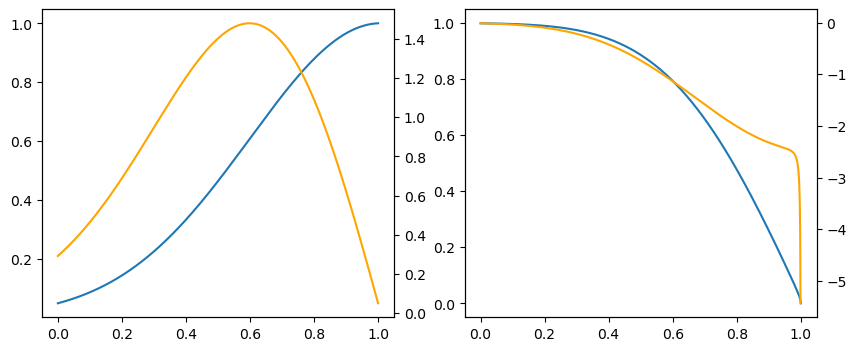

In [4]:
ts = torch.linspace(0., 1., 1000)

at, bt = model.interpolant_scheduler.interpolants(ts)
atp, btp = model.interpolant_scheduler.interpolants_prime(ts)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(ts, at.cpu())
ax[0].twinx().plot(ts, atp.cpu(), color='orange')

ax[1].plot(ts, bt.cpu())
ax[1].twinx().plot(ts, btp.cpu(), color='orange')
plt.show()

# Checking Sampling

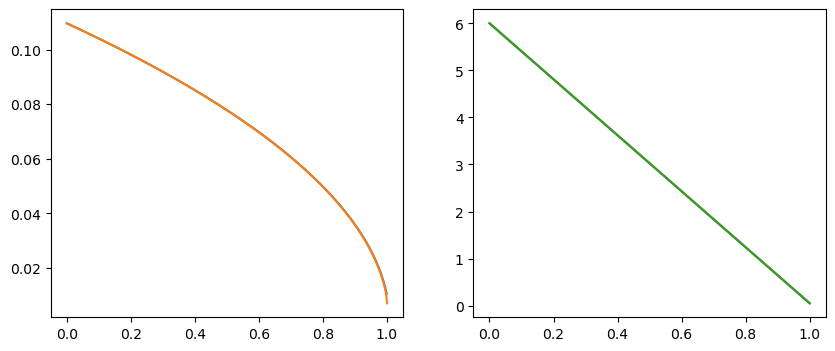

In [5]:
ts = torch.linspace(0., 1., 1000)

mem_sig = model.interpolant_scheduler.memoryless_sigma_t(ts)
def sig_fn_ddpm(t,tm1):
    at, sig = model.sde.get_alpha_sigma(t)
    atm1, _ = model.sde.get_alpha_sigma(tm1)
    sig_t = torch.sqrt((1-atm1)/(1-at+1e-5)*(1-at/atm1))
    return sig_t

ddpm_sigs = sig_fn_ddpm(ts[1:], ts[:-1])
at = model.sde.get_alpha_sigma(1. - ts)[0]

my_sig = torch.sqrt((at[1:] - at[:-1]) / at[:-1])

at, bt = model.interpolant_scheduler.interpolants(ts)
atp, btp = model.interpolant_scheduler.interpolants_prime(ts)
abart = model.sde.alpha_bar_t(1. - ts)
abartp = -model.sde.alpha_bar_t_prime(1. - ts)

etpred = 0.5 * abartp / abart
etreal = bt * (atp / at * bt - btp)

ktpred = etpred
ktreal = atp / at 

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(ts, mem_sig.cpu() * torch.sqrt(ts[1] - ts[0]))
ax[0].plot(ts[1:], ddpm_sigs.cpu().flip(dims=(0,)))

ax[1].plot(ts, etpred.cpu())
ax[1].plot(ts, etreal.cpu())
ax[1].plot(ts, ktreal.cpu())
plt.show()

/home/komodo/Documents/uni/generative-exploration/src/genexp/sampling.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_in = torch.tensor(t, device=device).expand(x.size(0))[:, None]


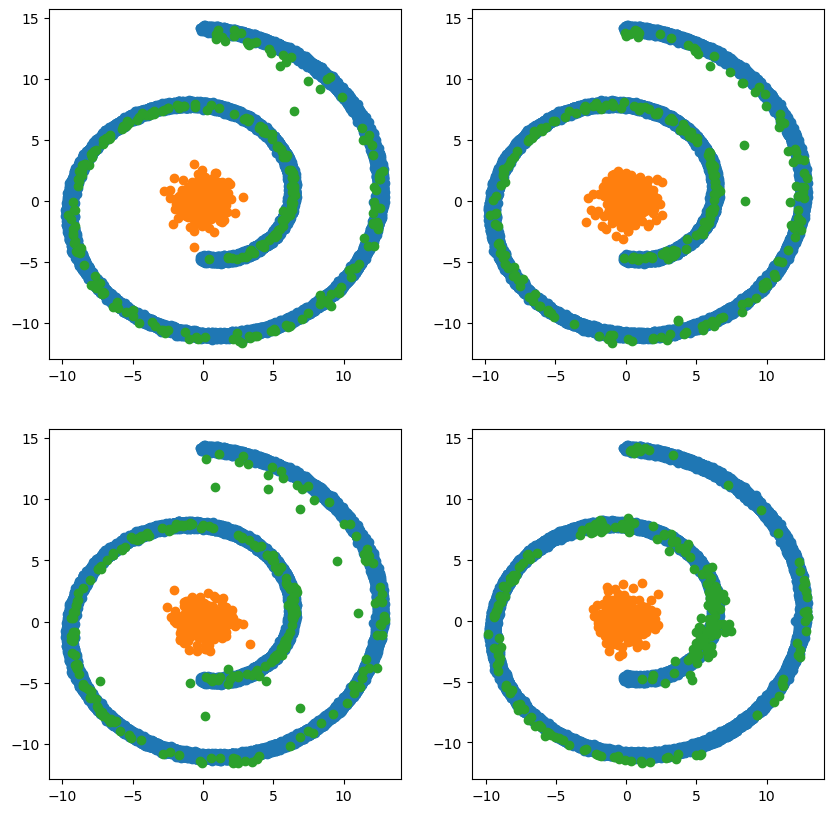

In [6]:
trajs, _ = DDIMSampler(model, (2,), device=device).sample_trajectories(256, 1000, sample_jumps=False)
trajs_mem, _ = MemorylessSampler(model, (2,), device=device).sample_trajectories(256, 1000, sample_jumps=False)
trajs_em, _ = EulerMaruyamaSampler(model, (2,), device=device, noise_func=lambda x: torch.zeros_like(x).to(x.device)).sample_trajectories(256, 1000, sample_jumps=False)
trajs_score, _ = EMDiffusionSampler(model, (2,)).sample_trajectories(256, 1000, sample_jumps=False)

%matplotlib inline

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].scatter(dataset[:, 0], dataset[:, 1])
ax[0, 0].scatter(trajs[:, 0, 0], trajs[:, 0, 1])
ax[0, 0].scatter(trajs[:, -1, 0], trajs[:, -1, 1])

ax[0, 1].scatter(dataset[:, 0], dataset[:, 1])
ax[0, 1].scatter(trajs_mem[:, 0, 0], trajs_mem[:, 0, 1])
ax[0, 1].scatter(trajs_mem[:, -1, 0], trajs_mem[:, -1, 1])

ax[1, 0].scatter(dataset[:, 0], dataset[:, 1])
ax[1, 0].scatter(trajs_em[:, 0, 0], trajs_em[:, 0, 1])
ax[1, 0].scatter(trajs_em[:, -1, 0], trajs_em[:, -1, 1])

ax[1, 1].scatter(dataset[:, 0], dataset[:, 1])
ax[1, 1].scatter(trajs_score[:, 0, 0], trajs_score[:, 0, 1])
ax[1, 1].scatter(trajs_score[:, -1, 0], trajs_score[:, -1, 1])

plt.show()